In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime as dt
import kaggle
import matplotlib.animation as animation
%matplotlib inline
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
sns.set(color_codes=True)
import plotly.figure_factory as ff
from collections import Counter
import squarify
from sklearn.preprocessing import MultiLabelBinarizer 
import networkx as nx
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

Download data from Kaggle using Kaggle API:

Step 1 : pip install kaggle <br>
step 2 : Create an account on Kaggle. In accounts click on Create API. This downloads kaggle.json which should be placed in ~/.kaggle <br>
Step 3 : Search the dataset of interest <br>
Step 4 : Download dataset to mentioned path <br>
<br>
<br>
!pip install kaggle <br>
!mkdir -p ~/.kaggle <br>
!cp kaggle.json ~/.kaggle/ <br>
!ls ~/.kaggle <br>
!chmod 600 /root/.kaggle/kaggle.json  # set permission <br>
!kaggle datasets list -s "Netflix Movies and TV Shows" # to search datasets <br>
!kaggle datasets download shivamb/netflix-shows -f netflix_titles.csv -p C:/Users/hp/Desktop/rec-flix/data/raw #to download dataset <br>
<br>


In [2]:
!kaggle datasets list -s "Disney+ Movies and TV Shows"

ref                                                       title                                                 size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
shivamb/disney-movies-and-tv-shows                        Disney+ Movies and TV Shows                          131KB  2021-11-29 02:25:49          12277        224  1.0              
shivamb/netflix-shows                                     Netflix Movies and TV Shows                            1MB  2021-09-27 04:44:36         271124       6894  1.0              
unanimad/disney-plus-shows                                Disney Plus Movies and TV Shows                      149KB  2020-05-16 13:39:58           2968         55  1.0              
victorsoeiro/disney-tv-shows-and-movies                   Disney+ TV Shows and Movies

In [3]:
!kaggle datasets download shivamb/disney-movies-and-tv-shows -f disney_plus_titles.csv -p C:/Users/hp/Desktop/rec-flix/data/raw


  0%|          | 0.00/375k [00:00<?, ?B/s]
100%|██████████| 375k/375k [00:00<00:00, 5.71MB/s]


Unzip the file either using zipfile module from python or using bash CLI tar command <br>
tar -xvf #extract files <br>
tar -cvf #creates zip files <br>

In [4]:
!tar -xvf C:/Users/hp/Desktop/rec-flix/data/raw/ C:/Users/hp/Desktop/rec-flix/data/raw/disney_plus_titles.csv.zip

tar: Error opening archive: Error reading 'C:/Users/hp/Desktop/rec-flix/data/raw/'


### Exploratory analysis

In [8]:
platforms = ['Netflix', 'Prime', 'Hulu', 'Disney']
platform = 'Disney'

In [9]:
#read file from path into a pandas dataframe
path = 'C:/Users/hp/Desktop/rec-flix/data/raw/'
filename = 'disney_plus_titles.csv'
df = pd.read_csv(os.path.join(path, filename))

In [10]:
print(f'Number of columns in {platform} dataset are : {df.shape[1]}')
print(f'Columns in {platform} dataset are : {df.columns.values.tolist()}')
print(f'Number of records in {platform} dataset are : {df.shape[0]}')

Number of columns in Disney dataset are : 12
Columns in Disney dataset are : ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']
Number of records in Disney dataset are : 1450


We would need date_added in our analysis and would need to know its dtype as we expect it to be of datetime type

In [11]:
display(df.dtypes)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

As date added is of type object we typecast it as datetime object and extract year and month for our analysis.

In [12]:
df['date_added']=pd.to_datetime(df['date_added'])
df['added_year']=df['date_added'].dt.year
df['added_month']=df['date_added'].dt.month
print("date_add field is of type: ",df.date_added.dtype)

date_add field is of type:  datetime64[ns]


In [13]:
#to check if there any null values in our dataframe and how we wil handle those
print(f'Number of columns that have null values : {str(df.isna().any().sum())}')
print(f'The columns with null values are : {df.columns[df.isnull().any()].values.tolist()}')

Number of columns that have null values : 7
The columns with null values are : ['director', 'cast', 'country', 'date_added', 'rating', 'added_year', 'added_month']


In [14]:
#unique categories, ratings and countries
print(f'Unique number of Categories : {df.listed_in.nunique()}')
print(f'Unique number of Ratings : {df.rating.nunique()}')
print(f'Top 5 Raings based on frequency :{df.rating.value_counts()[:5].index.to_list()}')
print(f'Unique countries : {df.country.nunique()}')
print(f'Top 5 Countries based on frequency :{df.country.value_counts()[:5].index.to_list()}')

Unique number of Categories : 329
Unique number of Ratings : 9
Top 5 Raings based on frequency :['TV-G', 'TV-PG', 'G', 'PG', 'TV-Y7']
Unique countries : 89
Top 5 Countries based on frequency :['United States', 'United States, Canada', 'United Kingdom', 'United States, United Kingdom', 'Canada, United States']


The content on platform can be of two major categories: Movies and Shows and we wish to know the distribution of them.

In [15]:
df_movies=df[df['type']=='Movie']
df_shows=df[df['type']=='TV Show']
print(f'Number of records of type movie are : {df_movies.shape[0]}')
print(f'Number of records of type show are : {df_shows.shape[0]}')

Number of records of type movie are : 1052
Number of records of type show are : 398


In [16]:
#function to format the pie-chart

def plott(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

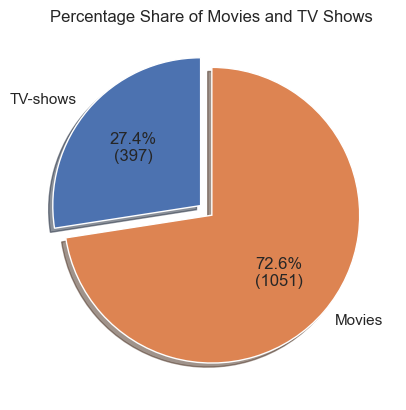

In [17]:
#creating a list to pass to function plott
content_type=[]
len_shows=len(df_movies)
len_movies=len(df_shows)
content_type.append(len_movies)
content_type.append(len_shows)

plt.figure()
plt.title("Percentage Share of Movies and TV Shows")
#plotting a pie chart since fewer labels are there
plt.pie(content_type,labels=['TV-shows','Movies'],shadow=True,startangle=90,explode=(0.10,0),autopct=lambda pct: plott(pct, content_type))
plt.show()

In [18]:
#toidentify each season of a show uniquely
df['count']=df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in str(x['duration']) else "", axis = 1)

### Analyzing content growth over years

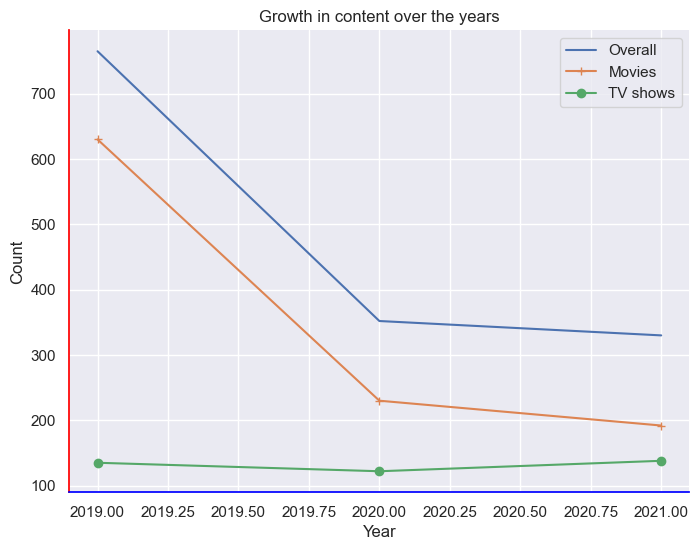

In [19]:
#Since time period(added_year) is same for both movies and TV shows, we take their count by frequency over added_year field
vc1=df['added_year'].value_counts()
vc2=df_movies['added_year'].value_counts()
vc3=df_shows['added_year'].value_counts()
vc1=vc1.sort_index()
vc2=vc2.sort_index()
vc3=vc3.sort_index()

fig=plt.figure(figsize=(8,6))
plt.title("Comaprative analysis of content growth over years")
plt.plot(vc1.index,vc1.values,label='Overall')
plt.plot(vc2.index,vc2.values,'-+',label='Movies')
plt.plot(vc3.index,vc3.values,'-o',label='TV shows')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Growth in content over the years')
plt.legend()
ax=plt.gca()
ax.spines['bottom'].set_color('blue')
ax.spines['left'].set_color('red')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [20]:
col = 'added_month'
vc4 = df[col].value_counts().reset_index()
vc4 = vc4.rename(columns = {col : "count", "index" : col})
#vc4['percent'] = vc4['count'].apply(lambda x : 100*x/sum(vc1['count']))
vc4 = vc4.sort_values(col)

trace1 = go.Bar(x=vc4[col], y=vc4["count"], name="content", marker=dict(color="#a678de"))
data = [trace1]
layout = go.Layout(title="Which month is most popular to add content?", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

In [21]:
#Oldest Content
small = df.sort_values("release_year", ascending = True)
small = small[small['duration'] != ""]
display(small[['title', "release_year"]][:5])

,title,release_year
1220,Steamboat Willie,1928
893,Flowers and Trees,1932
1178,Santa's Workshop,1932
736,Babes in the Woods,1932
1317,The Pied Piper,1933


In [22]:
#Latest Content
small = df.sort_values("release_year", ascending = False)
small = small[small['duration'] != ""]
display(small[['title', "release_year"]][:5])

,title,release_year
155,Stuntman,2021
315,WandaVision,2021
139,Killer Shark vs Killer Whale,2021
141,Cesar Millan: Better Human Better Dog,2021
143,Built for Mars: The Perseverance Rover,2021


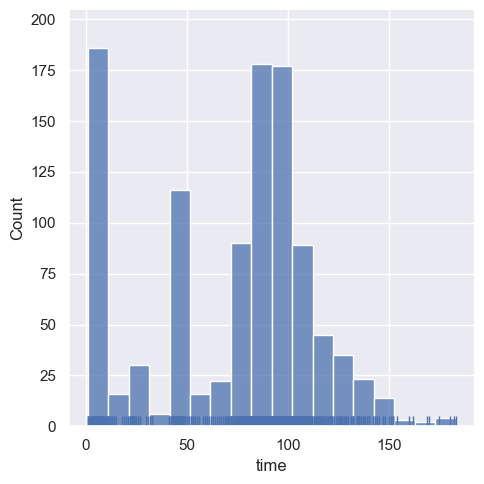

In [24]:
#To see how the duration of movie is didtributed
df_movies['time']=df_movies.apply(lambda x : str(x['duration']).split(" ")[0], axis = 1)
x2=df_movies['time'].astype(float)
sns.displot(x2,rug=True)
plt.show()

In [25]:
#Most common content on shows
col = "listed_in"
categories = ", ".join(df_shows['listed_in']).split(", ") 
counter_list=Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace=go.Bar(y=labels, x=values, orientation="h", name="TV Shows", marker=dict(color="#a678de"))
#print(type(trace))
data=[trace]
layout=go.Layout(title='Most common content in shows',legend=dict(x=0.1,y=1.1,orientation='h'))
fig=go.Figure(data,layout=layout)
fig.show()

In [26]:
#Most common content in Movies
col = "listed_in"
categories = ", ".join(df_movies['listed_in']).split(", ") 
counter_list=Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace=go.Bar(y=labels, x=values, orientation="h", name="Movies", marker=dict(color="#a678de"))
data=[trace]
layout=go.Layout(title='Most common content',legend=dict(x=0.1,y=1.1,orientation='h'))
fig=go.Figure(data,layout=layout)
fig.show()

In [27]:
#as we see above there are some categores which two categories are clubbed together, 
#we put them as two different categories and count them 
category=", ".join(df['listed_in']).split(", ")
cat_list=[]
for i in category:
    if "&" in i:
        t=i.split(" & ")
        cat_list.append(t[0])
        cat_list.append(t[1])
    else:
        cat_list.append(i) 
list_counter=Counter(cat_list)
print(f'Most common categories are : {list_counter.most_common(10)}')

Most common categories are : [('Family', 632), ('Animation', 542), ('Comedy', 526), ('Action-Adventure', 452), ('Animals', 208), ('Nature', 208), ('Coming of Age', 205), ('Fantasy', 192), ('Documentary', 174), ('Kids', 141)]


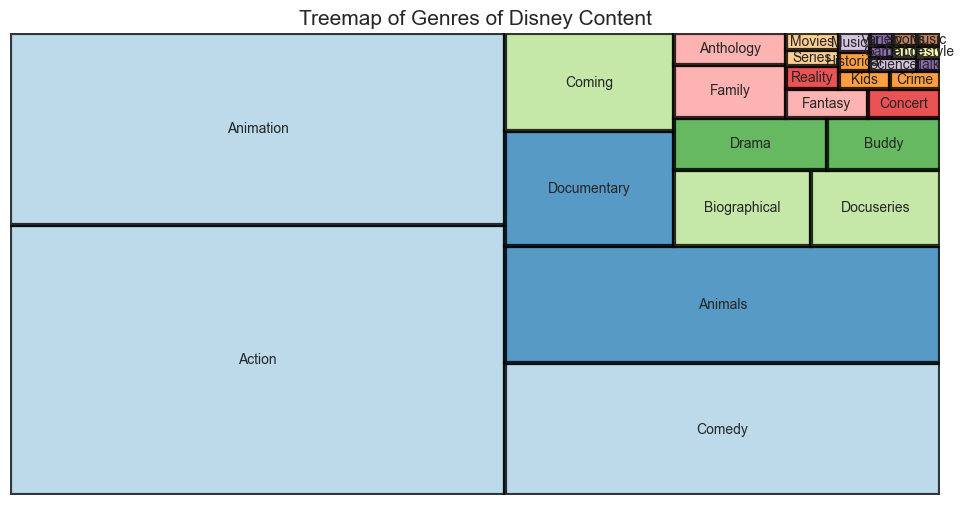

In [28]:
#plotting a tree map of Genres 
df['Genres']=df['listed_in'].str.extract('([A-Z]\w{2,})',expand=True)
temp_df=df['Genres'].value_counts().reset_index()
sizes=np.array(temp_df['Genres'])
labels=temp_df['index']
colors=[plt.cm.Paired(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(12,6),dpi=100)
squarify.plot(sizes=sizes,color=colors,label=labels,edgecolor='black',alpha=0.75, linewidth=3, text_kwargs={'fontsize':10})
plt.title(f'Treemap of Genres of {platform} Content', fontsize = 15)
plt.axis('off')
plt.show()

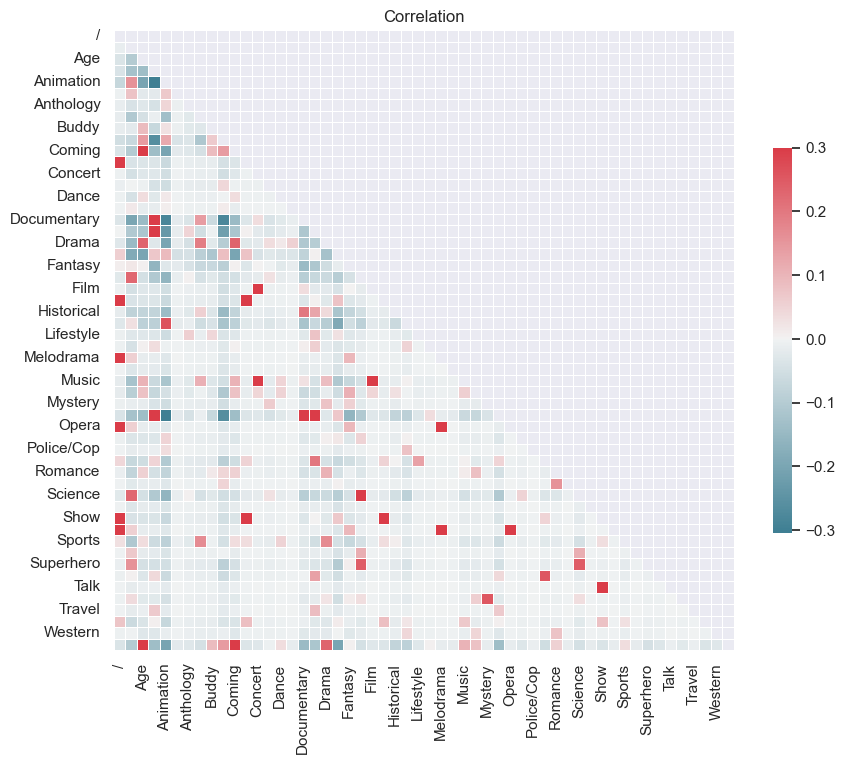

In [29]:
#using skleran multilabelbinarizer to generate one hot encode labels for listed i
#we are trying to identify correlation between categories
data=df['listed_in'].astype(str).apply(lambda s : s.replace('&',' ').replace(',',' ').split())
test=data
mlb=MultiLabelBinarizer()
res=pd.DataFrame(mlb.fit_transform(test),columns=mlb.classes_)
corr=res.corr()
#since upper and lower sides of diagonal are transpose , we mask upper matrix triangle as 0
mask=np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True
f,ax=plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation')
plt.show()

In [30]:
#using network graph to better understand how strongly are categories related to other categories
stocks=corr.index.values
cor_matrix=np.asmatrix(corr)
G=nx.from_numpy_matrix(cor_matrix)
G=nx.relabel_nodes(G,lambda x : stocks[x])
G.edges(data=True)


def create_corr_network(G,corr_direction,min_correlation):
    H=G.copy()
    for stock1,stock2,weight in G.edges(data=True):
        if corr_direction=='positive':
            if weight['weight']<0 or weight['weight']<min_correlation:
                H.remove_edge(stock1,stock2)
        else:
            if weight['weight']>=0 or weight['weight']>min_correlation:
                H.remove_edge(stock1,stock2)
    
    edges,weights=zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)
    
    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, font_family='sans-serif')
    
    if corr_direction == "positive": 
        edge_colour = plt.cm.GnBu 
    else: 
        edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

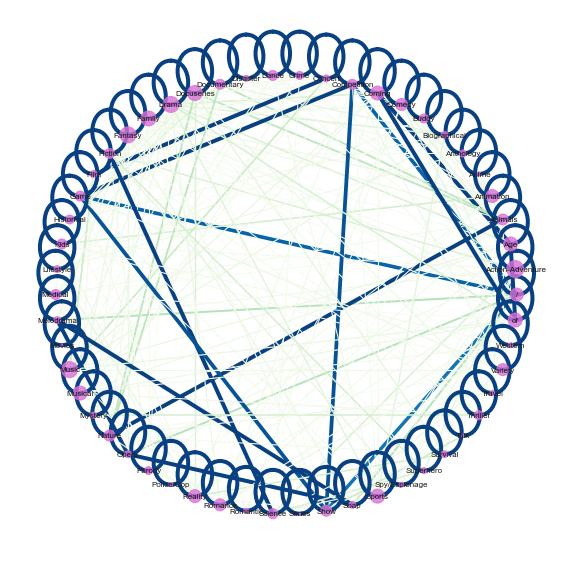

In [31]:
#create_corr_network(G, 'positive', 0.5)
create_corr_network(G, 'positive', -1.0)

In [32]:
#Country wise content
country_wise_content=df.country.value_counts().reset_index()[:20]
trace1=go.Bar(x=country_wise_content['index'],y=country_wise_content['country'],width=1.5)
layout=go.Layout(template= "plotly_dark",title = 'TOP 20 COUNTIES WITH MOST CONTENT' ,
                 xaxis = dict(title = 'Countries'),yaxis = dict(title = 'Count'))
fig=go.Figure(data=[trace1],layout=layout)
fig.show()

In [34]:
#Looking closely at USA
df_india=df[df['country'].str.contains('United State',na=False)]
#For movies
df_india_movie=df_india[df_india['type']=='Movie']
#most popular directors by the number of movies
categories=", ".join(df_india_movie.director.fillna("")).split(", ")
counter_list=Counter(categories).most_common(15)
counter_list = [_ for _ in counter_list if _[0] != ""]
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace=go.Bar(x=labels,y=values)
layout=go.Layout(template='plotly_dark',title='Most Famous Directors',xaxis=dict(title='Directors'),yaxis=dict(title='Count'))
fig=go.Figure(data=[trace],layout=layout)
fig.show()